In [69]:
import re
import glob
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import amino_acid_codes

## Load ref

In [2]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [3]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])
ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
10,N,[ORF9; structural protein],nucleocapsid phosphoprotein,YP_009724397.2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...


In [4]:
aa_freqs_df_ref = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df_ref.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df_ref

,M,E,S,L,V,P,G,F,N,K,T,H,Q,R,D,A,C,Y,I,W
ORF1ab,168,340,456,668,598,274,412,349,384,434,527,145,239,244,389,487,226,335,343,78
S,14,48,99,108,97,58,82,77,88,61,97,17,62,42,62,79,40,54,76,12
ORF3a,4,11,22,30,25,12,14,14,8,11,24,8,9,6,13,13,7,17,21,6
E,1,2,8,14,13,2,1,5,5,2,4,0,0,3,1,4,3,4,3,0
M,4,7,15,35,12,5,14,11,11,7,13,5,4,14,6,19,4,9,20,7
ORF6,3,5,4,8,3,1,0,3,4,4,3,1,3,1,4,1,0,2,10,1
ORF7a,1,8,7,15,8,6,4,10,2,7,10,3,5,5,2,9,6,5,8,0
ORF7b,2,3,2,11,1,0,0,6,1,0,1,2,1,0,2,2,2,1,5,1
ORF8,1,6,9,10,12,7,5,8,2,5,5,4,6,4,7,5,7,7,10,1
N,7,12,37,27,8,28,43,13,22,31,32,4,35,29,24,37,0,11,14,5


In [5]:
aa_freqs_total_dct_ref = aa_freqs_df_ref.sum(0).to_dict() #.rename(columns=amino_acid_codes)
aa_freqs_total_dct_ref

{'M': 207,
 'E': 442,
 'S': 661,
 'L': 930,
 'V': 781,
 'P': 394,
 'G': 576,
 'F': 500,
 'N': 532,
 'K': 562,
 'T': 718,
 'H': 189,
 'Q': 365,
 'R': 350,
 'D': 511,
 'A': 658,
 'C': 296,
 'Y': 448,
 'I': 513,
 'W': 111}

## Load genotypes from 2025

In [9]:
paths = glob.glob('./data/genotypes2025/gisaid_*.tsv')
paths

['./data/genotypes2025/gisaid_hcov-19_2025_05_29_10(7).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(6).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(5).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(4).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(3).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(2).tsv',
 './data/genotypes2025/gisaid_hcov-19_2025_05_29_10(1).tsv']

In [10]:
genotypes = pd.concat([pd.read_csv(paths[i], sep='\t', index_col=1) for i in range(len(paths))])
print(genotypes.shape)
genotypes.head(2)

(59916, 15)


,Virus name,Collection date,Location,Host,Passage,Specimen,Additional host information,Sampling strategy,Sequencing technology,Assembly method,Comment,Comment type,Lineage,Clade,AA Substitutions
Accession ID,,,,,,,,,,,,,,,
EPI_ISL_19674224,hCoV-19/Australia/QLD0x015057/2025,2025-01-01,Oceania / Australia / Queensland,Human,Original,NaN,NaN,NaN,Nanopore,NaN,Gap of 2 nucleotide(s) found at refpos 11084 (...,warn,MC.1 (consensus call),GRA,"(NSP5_P132H,Spike_H69del,NSP3_T1465I,NSP3_G489..."
EPI_ISL_19674372,hCoV-19/Australia/SA2318258/2025,2025-01-02,Oceania / Australia / South Australia,Human,Original,NaN,NaN,NaN,Nanopore MinION,NaN,Gap of 45 nucleotides when compared to the ref...,warn,KP.3.1.1 (consensus call),GRA,"(NSP5_P132H,Spike_H69del,NSP3_T1465I,NSP3_G489..."


In [11]:
genotypes.Host.value_counts()

Host
Human    59916
Name: count, dtype: int64

In [12]:
genotypes.Passage.value_counts()

Passage
Original              59862
Culture passage 0        46
Vero E6, P2               3
Vero E6/TMPRSS2 P0        2
Vero E6/TMPRSS2 P1        2
Vero E6 P2                1
Name: count, dtype: int64

In [13]:
genotypes['Lineage'].value_counts().head(10)

Lineage
XEC (consensus call)          13887
LP.8.1.1 (consensus call)      5829
KP.3.1.1 (consensus call)      2868
LP.8.1 (consensus call)        2600
MC.1 (consensus call)          1380
XEC                            1366
JN.1.11 (consensus call)       1175
JN.1.16.1 (consensus call)     1160
XEC.4 (consensus call)         1111
XEC.2 (consensus call)         1060
Name: count, dtype: int64

In [14]:
genotypes['Clade'].value_counts()

Clade
GRA    59414
GR       490
G          5
O          2
GK         1
Name: count, dtype: int64

In [15]:
genotypes['Collection date'].agg(['min', 'max'])

min    2025-01-01
max    2025-05-22
Name: Collection date, dtype: object

In [16]:
genotypes = genotypes.query('Clade == "GRA" & Passage == "Original"')
genotypes.shape

(59361, 15)

In [17]:
genotypes.index.to_series().to_csv('./data/genotypes2025/AccessionIDs.tsv', 
                                   sep='\t', index=False, header=False)

In [18]:
# Mutability of proteins

genotypes['AA Substitutions'].apply(
    lambda x: pd.Series(Counter([y.split('_')[0] for y in x.strip('()').split(',')])))\
        .mean(0).sort_values(ascending=False)

Spike    65.118175
N         8.079766
NSP3      7.521875
NSP6      4.977307
M         4.959254
NSP4      3.103341
NSP2      1.541883
NS3       1.521179
NS6       1.431631
NS7a      1.346249
NSP1      1.317833
NS8       1.229696
NSP12     1.181781
NSP14     1.167849
NSP13     1.130279
NSP15     1.086080
NSP5      1.076391
NSP16     1.060511
NSP9      1.045010
NSP8      1.037418
NSP7      1.027287
NSP10     1.021456
NS7b      1.018954
E         1.007606
dtype: float64

In [20]:
def collect_difference(aa_sbs: str, use_genes=None):
    use_genes = set(use_genes) if use_genes is not None else None

    aa_content_delta = defaultdict(int)

    for x in aa_sbs.strip('()').split(','):
        gene,mut = x.split('_')
        m = bool(re.match(r'^[A-Z]\d+[A-Z]$', mut))
        if m:
            if use_genes is not None and gene not in use_genes:
                continue
            aa1, aa2 = mut[0], mut[-1]
            aa_content_delta[aa1] -= 1
            aa_content_delta[aa2] += 1

        elif not m and not mut.endswith('del') and not mut.startswith('ins') and not mut.endswith('stop'):
            print('WARNING:', gene, mut, x)
    
    return pd.Series(aa_content_delta)

In [21]:
aa_delta = genotypes['AA Substitutions'].apply(collect_difference).fillna(0.)
aa_delta

,P,H,T,I,G,S,E,K,N,Y,...,Q,L,F,V,D,W,M,J,B,Z
Accession ID,,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19674224,-4.0,4.0,-9.0,9.0,-2.0,-2.0,0.0,9.0,-5.0,2.0,...,-5.0,3.0,4.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19674372,-4.0,4.0,-8.0,8.0,-2.0,0.0,0.0,10.0,-5.0,2.0,...,-5.0,3.0,3.0,-2.0,0.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19675602,-4.0,4.0,-8.0,8.0,-2.0,-1.0,0.0,9.0,-5.0,2.0,...,-5.0,3.0,3.0,-2.0,0.0,2.0,0.0,0.0,0.0,0.0
EPI_ISL_19674356,-3.0,4.0,-7.0,7.0,-2.0,1.0,0.0,10.0,-4.0,2.0,...,-5.0,3.0,2.0,-1.0,0.0,1.0,-1.0,0.0,0.0,0.0
EPI_ISL_19674361,-5.0,3.0,-7.0,8.0,-2.0,0.0,1.0,7.0,-5.0,2.0,...,-5.0,5.0,3.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,-3.0,3.0,-6.0,7.0,-2.0,-1.0,0.0,8.0,-5.0,2.0,...,-5.0,3.0,3.0,-1.0,1.0,1.0,0.0,0.0,0.0,0.0
EPI_ISL_19885820,-5.0,3.0,-7.0,8.0,-2.0,0.0,0.0,8.0,-5.0,2.0,...,-5.0,5.0,3.0,1.0,0.0,1.0,-1.0,0.0,0.0,0.0
EPI_ISL_19885830,-6.0,3.0,-7.0,8.0,-2.0,2.0,0.0,8.0,-5.0,2.0,...,-5.0,4.0,3.0,-1.0,0.0,1.0,0.0,0.0,0.0,0.0


In [22]:
# mean change
aa_delta.fillna(0).mean(0).sort_values(ascending=False)

K    9.069878
I    7.955661
H    3.654824
L    3.454120
F    2.753070
Y    2.089773
C    1.223750
W    0.941763
S    0.329594
B    0.002780
J    0.002072
Z    0.002038
M   -0.026212
D   -0.110898
E   -0.165092
R   -1.181887
V   -1.266000
G   -2.053385
P   -3.926703
N   -4.273782
Q   -4.848048
A   -5.928556
T   -7.698758
dtype: float64

## Plot differences from REF

### All proteins

In [24]:
aa_content_full = aa_delta.drop(['J', 'B', 'Z'], axis=1).fillna(0) + aa_freqs_total_dct_ref
aa_content_full

,P,H,T,I,G,S,E,K,N,Y,C,R,A,Q,L,F,V,D,W,M
Accession ID,,,,,,,,,,,,,,,,,,,,
EPI_ISL_19674224,390.0,193.0,709.0,522.0,574.0,659.0,442.0,571.0,527.0,450.0,298.0,350.0,653.0,360.0,933.0,504.0,779.0,511.0,112.0,207.0
EPI_ISL_19674372,390.0,193.0,710.0,521.0,574.0,661.0,442.0,572.0,527.0,450.0,298.0,349.0,652.0,360.0,933.0,503.0,779.0,511.0,112.0,207.0
EPI_ISL_19675602,390.0,193.0,710.0,521.0,574.0,660.0,442.0,571.0,527.0,450.0,298.0,349.0,653.0,360.0,933.0,503.0,779.0,511.0,113.0,207.0
EPI_ISL_19674356,391.0,193.0,711.0,520.0,574.0,662.0,442.0,572.0,528.0,450.0,297.0,348.0,652.0,360.0,933.0,502.0,780.0,511.0,112.0,206.0
EPI_ISL_19674361,389.0,192.0,711.0,521.0,574.0,661.0,443.0,569.0,527.0,450.0,297.0,350.0,652.0,360.0,935.0,503.0,780.0,511.0,112.0,207.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
EPI_ISL_19885825,391.0,192.0,712.0,520.0,574.0,660.0,442.0,570.0,527.0,450.0,297.0,350.0,652.0,360.0,933.0,503.0,780.0,512.0,112.0,207.0
EPI_ISL_19885820,389.0,192.0,711.0,521.0,574.0,661.0,442.0,570.0,527.0,450.0,297.0,350.0,651.0,360.0,935.0,503.0,782.0,511.0,112.0,206.0
EPI_ISL_19885830,388.0,192.0,711.0,521.0,574.0,663.0,442.0,570.0,527.0,450.0,297.0,350.0,652.0,360.0,934.0,503.0,780.0,511.0,112.0,207.0


In [77]:
sum(aa_freqs_total_dct_ref.values())

9744

In [78]:
aa_eq_freqs_20A = pd.read_csv('./data/aa_eq_freqs.csv', index_col=0)
aa_eq_freqs_20A.columns = ['eq_freq']
aa_eq_freqs_20A['eq_freq'] = aa_eq_freqs_20A['eq_freq'] * sum(aa_freqs_total_dct_ref.values())
aa_eq_freqs_20A

,eq_freq
aa,
Phe,4415.620230
Leu,1566.948022
Ile,1164.627177
Tyr,970.364847
Ser,568.835048
Asn,213.244774
Val,203.786650
Cys,165.108559
Thr,117.032029


In [193]:
data_freqs = pd.concat([
    pd.Series(aa_freqs_total_dct_ref, name='Reference').rename(index=amino_acid_codes),
    aa_content_full.mean(0).rename('gisaid_2025').rename(index=amino_acid_codes), 
    aa_eq_freqs_20A,
] ,axis=1)
data_freqs['exp_direction'] = (data_freqs['eq_freq'] - data_freqs['Reference']) / data_freqs['Reference']*100
# data_freqs['exp_direction'] = data_freqs['exp_direction'] / data_freqs['exp_direction'].abs()
data_freqs['obs_direction'] = (data_freqs['gisaid_2025'] - data_freqs['Reference']) / data_freqs['Reference']*100
# data_freqs['obs_direction'] = data_freqs['obs_direction'] / data_freqs['obs_direction'].abs()
data_freqs['correct_direction'] = data_freqs['exp_direction'].gt(0) == data_freqs['obs_direction'].gt(0)
data_freqs

,Reference,gisaid_2025,eq_freq,exp_direction,obs_direction,correct_direction
Met,207,206.973788,33.053932,-84.031917,-0.012663,True
Glu,442,441.834908,8.499794,-98.076970,-0.037351,True
Ser,661,661.329594,568.835048,-13.943261,0.049863,False
Leu,930,933.454120,1566.948022,68.489035,0.371411,True
Val,781,779.734000,203.786650,-73.906959,-0.162100,True
Pro,394,390.073297,52.038519,-86.792254,-0.996625,True
Gly,576,573.946615,7.619976,-98.677088,-0.356490,True
Phe,500,502.753070,4415.620230,783.124046,0.550614,True
Asn,532,527.726218,213.244774,-59.916396,-0.803343,True
Lys,562,571.069878,49.954411,-91.111315,1.613857,False


In [194]:
data_freqs.sum(0).round(2)

Reference            9744.00
gisaid_2025          9743.99
eq_freq              9744.00
exp_direction        -159.57
obs_direction           1.77
correct_direction      15.00
dtype: float64

In [202]:
data_freqs.head(2)

,Reference,gisaid_2025,eq_freq,exp_direction,obs_direction,correct_direction
Met,207,206.973788,33.053932,-84.031917,-0.012663,True
Glu,442,441.834908,8.499794,-98.076970,-0.037351,True


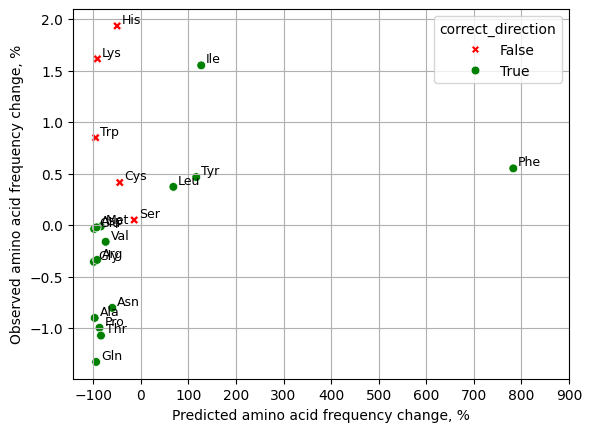

In [218]:
sns.scatterplot(data_freqs, x='exp_direction', y='obs_direction', 
                style='correct_direction', hue='correct_direction',
                markers={True: 'o', False: 'X'}, s=40, palette={True: 'green', False: 'red'})
for aa, row in data_freqs.iterrows():
    plt.text(row['exp_direction']+10, row['obs_direction'], aa, fontsize=9, ha='left', va='bottom')
plt.grid()
plt.xlabel('Predicted amino acid frequency change, %')
plt.ylabel('Observed amino acid frequency change, %')
plt.xticks(np.arange(-100, 1000, 100))
plt.savefig('./figures/aa_freqs_change.pdf', bbox_inches='tight')
plt.show()

<Axes: >

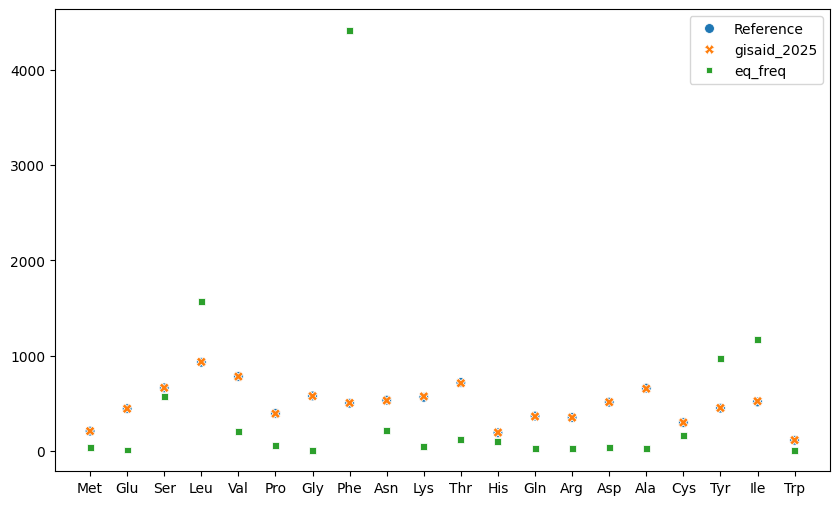

In [199]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data_freqs.iloc[:, :3], s=50)

<Axes: >

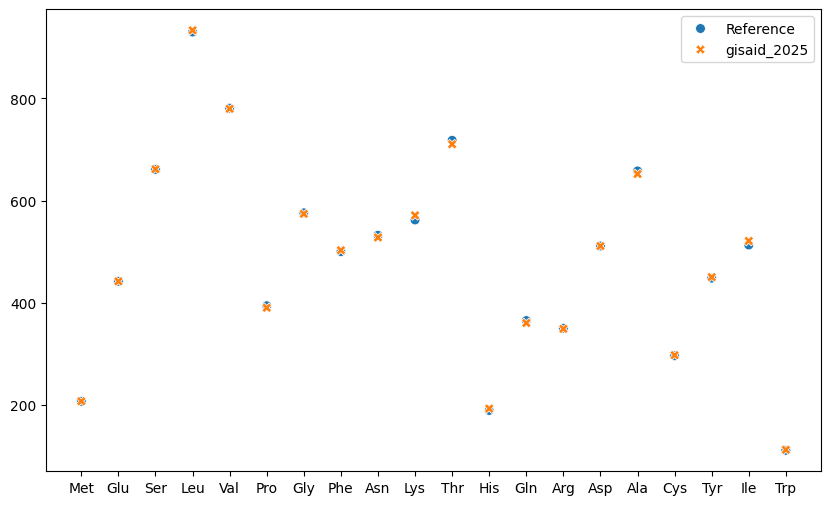

In [200]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data_freqs.iloc[:, :2], s=50)

(0, 207)


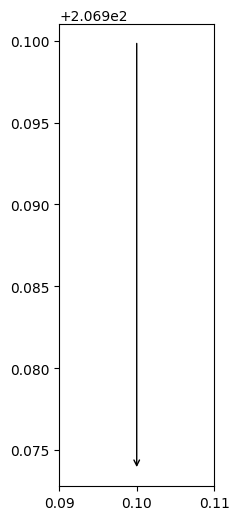

In [167]:
for aa, row in data_freqs.iterrows():
    # plt.text(row['exp_direction'], row['obs_direction'], aa, fontsize=12)
    # plt.scatter([0, 0], [row['Reference'], row['gisaid_2025']],)
    fig, ax = plt.subplots(figsize=(2, 6))
    print((0, row['Reference']))
    y1, y2 = row['Reference'], row['gisaid_2025']
    ax.annotate("", xytext=(0.1, y1), xy=(0.1, y2),
            arrowprops=dict(arrowstyle="->"))
    plt.xlim(0.1-0.01, 0.1+0.01)
    plt.ylim(min(row['Reference'], row['gisaid_2025']) - 0.001, 
             max(row['Reference'], row['gisaid_2025']) + 0.001)
    # plt.arrow(0, row['Reference'], 0, row['gisaid_2025'], width=0.01, 
    #           head_width=0.05, head_length=0.05,
    #             color='blue' if row['correct_direction'] else 'red',
    # )
    break

(2.0500000000000003, 2.15)

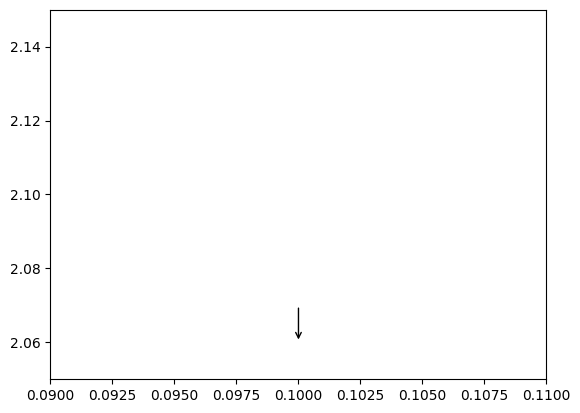

In [160]:
ax = plt.gca()
ax.annotate("", xytext=(0.1, 2.07), xy=(0.1, 2.06),
            arrowprops=dict(arrowstyle="->"))
plt.xlim(0.1-0.01, 0.1+0.01)
plt.ylim(2.1-0.05, 2.1+0.05)